# Rotating Optical Constants

Using the optical tensor derived from the linear dichrosim measured with experimental nexafs,
this notebook works though the process of converting from the molecular reference frame to the
material reference frame. The molecular reference frame is defined by the orientation of 
the transition dipole moment associate with the primary $\pi^*$ resonant feature. This TDM orientation
defines the out of plane, extrodinary, or $zz$ optical axis. The ordinary, or in-plane optical axes
are defined to be perpandicular to this $zz$ axis. 

The material optical model can be derived by the ensemble average of properly rotated molecules. 
We approximate this process by rotating the optical model by the average molecular tilt angle,
i.e., 
$$
    \tilde{n}(\vec\theta) = R(\theta)\tilde{n}'R(\vec\theta)^T
$$
where $R(\theta)$ is the rotation matrix describing the proper molecular rotation. Most molecules 
are approximated as uniaxial materials, azamuthal symmetry. In this case, the only angle that maters
is the polar angle $\theta$. 

,μ₂₀,μ₄₀,μ₅₅,μ₇₀,μ₉₀,Energy [eV]
0,0.027746,0.022804,0.039764,0.036376,0.074818,269.997974
1,0.005086,0.009765,0.023535,0.014884,0.049268,270.995049
2,0.008598,0.005768,0.019691,0.016241,0.049445,272.012929
3,0.015199,0.016635,0.025084,0.014820,0.033555,272.995692
4,0.023978,0.028465,0.013544,0.024076,0.027752,274.003729


[]

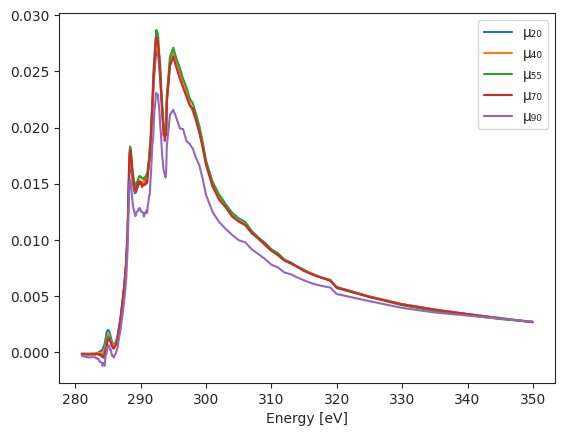

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_style("ticks")

directory = Path().home() / "projects/xrr_notebooks"

raw = pd.read_csv(directory/"optical models/NEXAFS_PFSBMA_2s.csv")
# drop the first row
energy_cols = [col for col in raw.columns if "Energy" in col]
# make a new column e [eV] that is the average of the energy columns
raw["Energy [eV]"] = raw[energy_cols].mean(axis=1)
raw = raw.drop(energy_cols, axis=1).sort_values("Energy [eV]")
raw.rename(columns={'20 deg': "μ₂₀", '40 deg': "μ₄₀", '55 deg': "μ₅₅", '70 deg': "μ₇₀", '90 deg': "μ₉₀"}, inplace=True)
mu = raw.div(raw["Energy [eV]"], axis=0)
mu["Energy [eV]"] = raw["Energy [eV]"]

display(raw.head())
# mask out after 340
mu = mu[(mu["Energy [eV]"] < 350) & (mu["Energy [eV]"] > 280)]
mu.plot(x="Energy [eV]")

plt.plot()

<Axes: xlabel='Energy [eV]'>

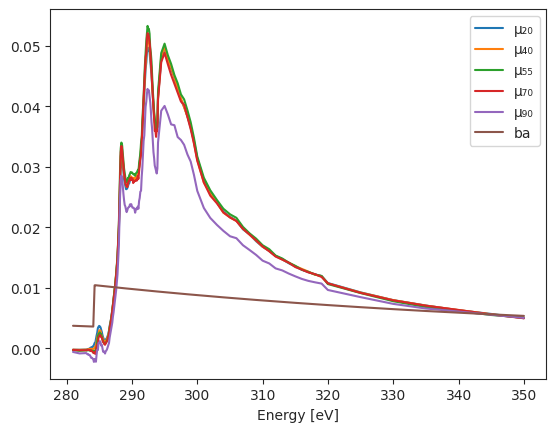

In [29]:
# Normalize the data to bare atom values
from periodictable import xsf
import matplotlib.pyplot as plt

ba = (
    -1
    * xsf.index_of_refraction(
        "C21F17H30N1O5S2", density=12, energy=mu["Energy [eV]"].values * 1e-3
    ).imag
)

# Using the first and last three points, dtermine the scale factor to normalize the data
scale_pre = np.mean(ba[:3] / mu["μ₂₀"].values[:3])
scale_pos = np.mean(ba[-3:] / mu["μ₂₀"].values[-3:])
scale = (scale_pos + scale_pos) / 2
mu_norm = mu.mul(scale)
mu_norm["ba"] = ba
mu_norm["Energy [eV]"] = mu["Energy [eV]"]
mu_norm.plot(x="Energy [eV]")

<Axes: xlabel='Energy [eV]'>

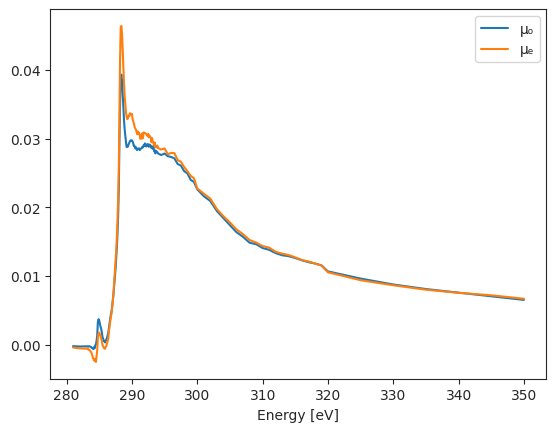

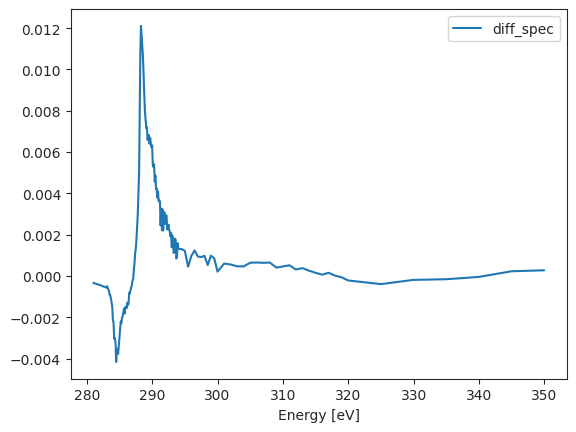

In [22]:
# Determine the difference spectrum for the dataset
input = pd.DataFrame()
input["Energy [eV]"] = mu_norm["Energy [eV]"]
input["diff_spec"] = mu_norm["μ₉₀"] - mu_norm["μ₂₀"]
# Max difference spectrum is the primary peak
primary_peak = input.loc[input["diff_spec"].idxmin()]
lower_bound = mu_norm.loc[mu_norm["ba"].idxmin()]

mu_av = mu_norm["μ₅₅"].loc[primary_peak.name]

ratio = mu_av / primary_peak["diff_spec"]
bound = 0*lower_bound["ba"] / primary_peak["diff_spec"]

input["μₒ"] = mu_norm["μ₅₅"] - (ratio - bound) * input["diff_spec"]
input["μₑ"] = mu_norm["μ₅₅"] + 2 * ratio * input["diff_spec"]

input.plot(x="Energy [eV]", y=["μₒ", "μₑ"])
input.plot(x="Energy [eV]", y="diff_spec")

,Energy [eV],$\delta_\parallel$,$\delta_\perp$,$\beta_\parallel$,$\beta_\perp$
0,10.00000,-0.318120,-0.319036,0.251016,0.251016
1,10.16170,-0.331674,-0.332562,0.254527,0.254527
2,10.18225,-0.323680,-0.324564,0.254982,0.254982
3,10.20280,-0.316674,-0.317554,0.255431,0.255431
4,10.24390,-0.304928,-0.305802,0.256312,0.256312


(-0.006, 0.006)

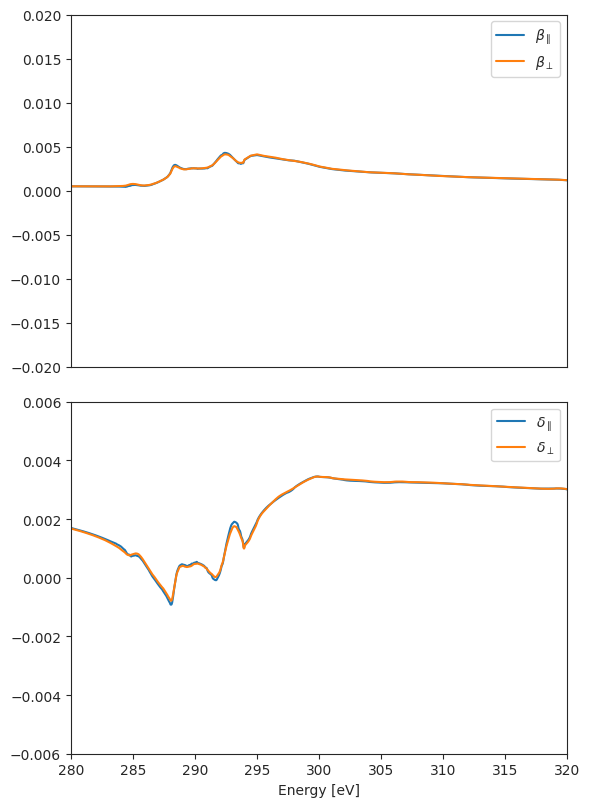

In [ ]:
# Kramers-Kronig transform
import kkcalc as kk
from numpy import interp

preped_data_set_e = mu[["Energy [eV]", "μ₂₀"]].values
preped_data_set_o = mu[["Energy [eV]", "μ₉₀"]].values

calc_e = kk.kk_calculate_real(
    preped_data_set_e,
    "C21F17H30N1O5S2",
    input_data_type="beta",
    load_options=None,
    merge_points=[input["Energy [eV]"].min(), input["Energy [eV]"].max()],
    add_background=False,
    fix_distortions=False,
    curve_tolerance=0.05,
    curve_recursion=100,
)

calc_o = kk.kk_calculate_real(
    preped_data_set_o,
    "C21F17H30N1O5S2",
    input_data_type="beta",
    load_options=None,
    merge_points=[input["Energy [eV]"].min(), input["Energy [eV]"].max()],
    add_background=False,
    fix_distortions=False,
    curve_tolerance=0.05,
    curve_recursion=100,
)

stoich = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoich)

δ_ip = kk.data.convert_data(
    calc_o[:, [0, 1]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

δ_op = kk.data.convert_data(
    calc_e[:, [0, 1]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

β_ip = kk.data.convert_data(
    calc_o[:, [0, 2]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

β_op = kk.data.convert_data(
    calc_e[:, [0, 2]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

en = δ_ip[:, 0] if δ_ip[:, 0].size > δ_op[:, 0].size else δ_op[:, 0]

# interpolate the lower points to the higher points
δ_ip = interp(en, δ_ip[:, 0], δ_ip[:, 1])
δ_op = interp(en, δ_op[:, 0], δ_op[:, 1])
β_ip = interp(en, β_ip[:, 0], β_ip[:, 1])
β_op = interp(en, β_op[:, 0], β_op[:, 1])

ooc = pd.DataFrame(
    {
        "Energy [eV]": en,
        r"$\delta_\parallel$": δ_ip,
        r"$\delta_\perp$": δ_op,
        r"$\beta_\parallel$": β_ip,
        r"$\beta_\perp$": β_op,
    }
)
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(6.4, 9.6))

ooc.plot(x="Energy [eV]", y=[r"$\beta_\parallel$", r"$\beta_\perp$"], ax=ax[0])
ooc.plot(x="Energy [eV]", y=[r"$\delta_\parallel$", r"$\delta_\perp$"], ax=ax[1])

display(ooc.head())

ax[0].set_xlim(280, 320)
ax[0].set_ylim(-.02, 0.02)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[1].set_xlim(280, 320)
ax[1].set_ylim(-0.006, 0.006)

In [40]:
def R(theta: float) -> np.ndarray:
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


n = np.zeros((len(en), 2, 2), dtype=complex)
n[:, 0, 0] = δ_ip + 1j * β_ip
n[:, 1, 1] = δ_op + 1j * β_op

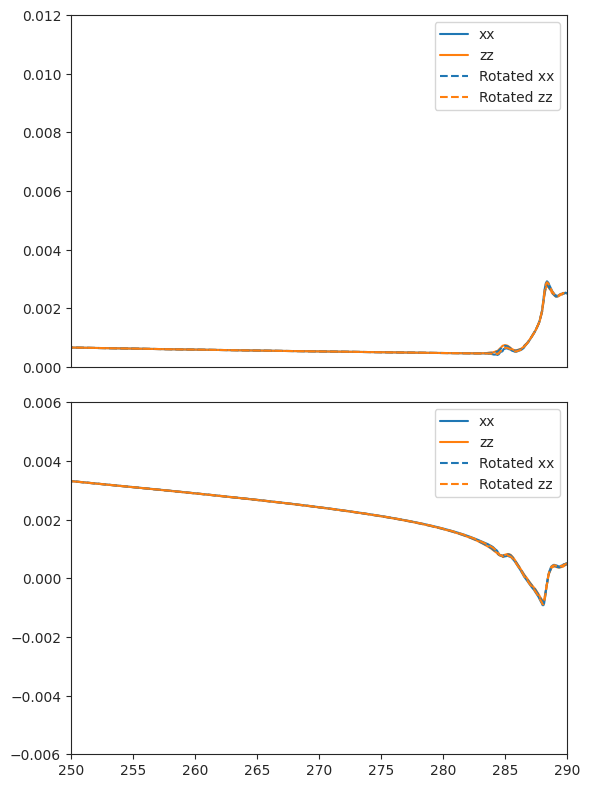

In [41]:
# theta from molecular tilt angle in .cif file

theta = np.deg2rad(61.83)
r = R(theta)
n_r = r @ n @ r.T

fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(6.4, 9.6))

ax[0].plot(en, n[:, 0, 0].imag, label="xx", color="C0")
ax[0].plot(en, n[:, 1, 1].imag, label="zz", color="C1")
ax[0].plot(en, n_r[:, 0, 0].imag, label="Rotated xx", color="C0", linestyle="--")
ax[0].plot(en, n_r[:, 1, 1].imag, label="Rotated zz", color="C1", linestyle="--")
ax[0].set_xlim(250, 290)
ax[0].set_ylim(0, 0.012)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].legend()

ax[1].plot(en, n[:, 0, 0].real, label="xx", color="C0")
ax[1].plot(en, n[:, 1, 1].real, label="zz", color="C1")
ax[1].plot(en, n_r[:, 0, 0].real, label="Rotated xx", color="C0", linestyle="--")
ax[1].plot(en, n_r[:, 1, 1].real, label="Rotated zz", color="C1", linestyle="--")
ax[1].set_xlim(250, 290)
ax[1].set_ylim(-0.006, 0.006)
ax[1].legend()

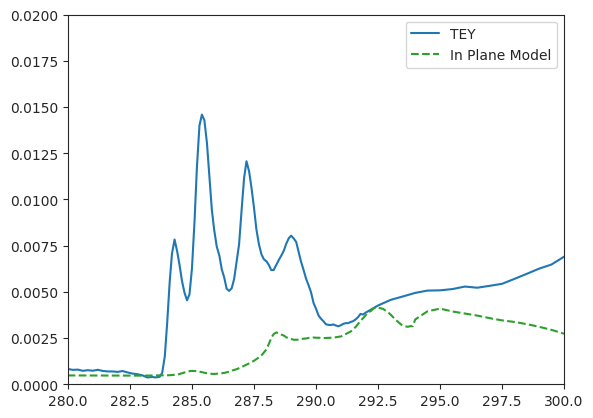

In [42]:
c_edge = pd.read_csv(directory / "optical models/znpc_55_56932.txt", delimiter="\t", skiprows=15)

# scale the signal so the pre edge is zero
tey = c_edge["TEY signal"].values - (c_edge["TEY signal"].where(c_edge["Beamline Energy"] < 283).mean() - n_r[:, 0, 0].real[(en < 283) & (en > 280)].mean())
tey /=2


plt.plot(c_edge["Beamline Energy"], tey, label="TEY", color="C0")

plt.plot(en, n_r[:, 0, 0].imag, color="C2", linestyle="--", label = "In Plane Model")

plt.xlim(280, 300)
plt.ylim(0, 0.02)
plt.legend()


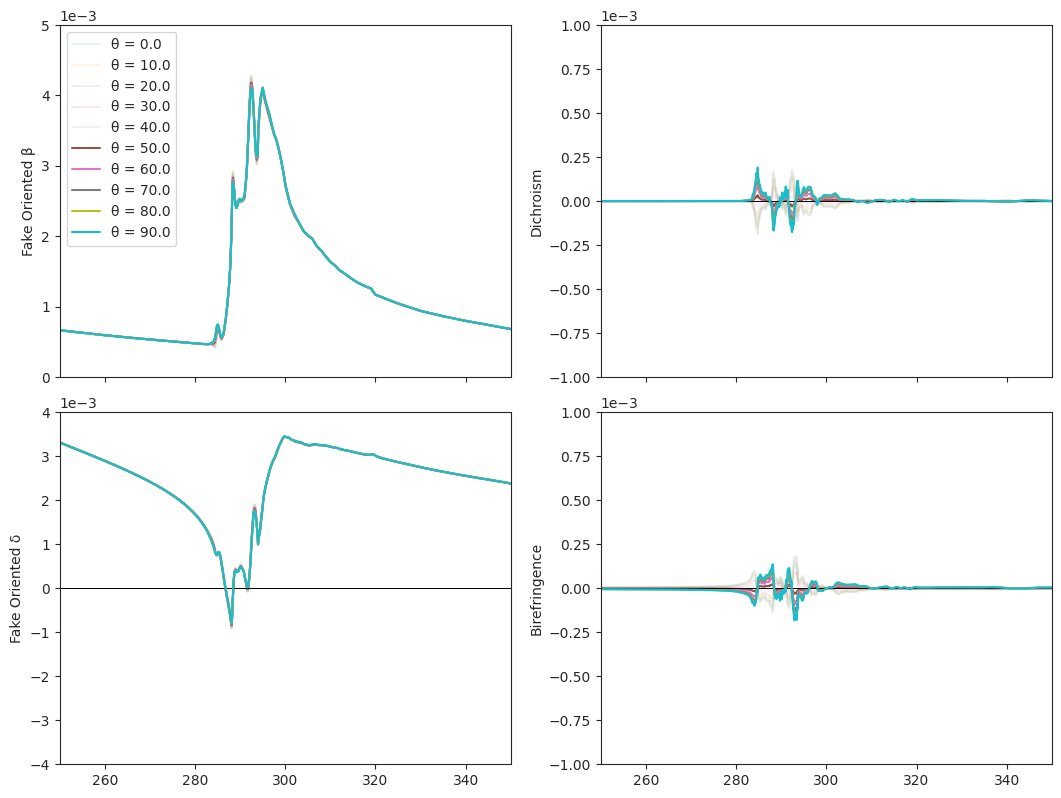

In [43]:
# convert n into a interpolated function
from scipy.interpolate import interp1d

def n_interp(en, deg):
    r = R(np.deg2rad(deg))
    n_r = r @ n @ r.T
    n_r_interp = interp1d(en, n_r, axis=0)
    return n_r_interp


thetas = np.linspace(0, 90, 10)
n_interp_f = [n_interp(en, theta) for theta in thetas]

fig, ax = plt.subplots(nrows=2, ncols = 2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(12.8, 9.6))

for i, n_r_interp in enumerate(n_interp_f):
    s = .1 if i<5 else 1

    ax[0,0].plot(en, n_r_interp(en)[:, 0, 0].imag, alpha = s)
    ax[0,0].set_xlim(250, 350)
    ax[0,0].set_ylim(0, 0.005)
    dichroism = n_r_interp(en)[:, 0, 0].imag - n_r_interp(en)[:, 1, 1].imag
    ax[0,0].legend([f"θ = {theta}" for theta in thetas], loc="upper left")
    ax[0,0].set_ylabel("Fake Oriented β")
    ax[0,0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax[0,1].axhline(0, color="black", linewidth=0.5)
    ax[0,1].plot(en, dichroism, alpha = s)
    ax[0,1].set_xlim(250, 350)
    ax[0,1].set_ylim(-0.001, 0.001)
    ax[0,1].set_ylabel("Dichroism")
    ax[0,1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))


    ax[1,0].axhline(0, color="black", linewidth=0.5)
    ax[1, 0].plot(en, n_r_interp(en)[:, 0, 0].real, alpha = s)
    ax[1,0].set_xlim(250, 350)
    ax[1,0].set_ylim(-0.004, 0.004)
    biren = n_r_interp(en)[:, 0, 0].real - n_r_interp(en)[:, 1, 1].real
    ax[1,0].set_ylabel("Fake Oriented δ")
    ax[1,0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax[1,1].axhline(0, color="black", linewidth=0.5)
    ax[1, 1].plot(en, biren, alpha = s)
    ax[1,1].set_xlim(250, 350)
    ax[1,1].set_ylim(-0.001, 0.001)
    ax[1,1].set_ylabel("Birefringence")
    ax[1,1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))





,xx,zz,dxx,dzz,delta,ddelta,ixx,izz,dixx,dizz,beta,dbeta,energy
0,0.001153,0.001163,0.000013,0.000003,0.000939,NaN,0.000201,0.000201,0.000000e+00,0.000000e+00,0.000201,NaN,275.0
1,0.000727,0.000858,0.000051,0.000016,0.000329,NaN,0.000197,0.000197,2.181875e-10,2.224330e-10,0.000197,NaN,280.0
2,0.000428,0.000772,0.000031,0.000013,0.000081,NaN,0.000198,0.000198,6.298336e-07,6.415796e-07,0.000197,NaN,281.0
3,0.000149,0.000641,0.000030,0.000029,-0.000303,NaN,0.000199,0.000200,1.425224e-06,1.470028e-06,0.000198,NaN,282.0
4,0.000032,0.000615,0.000007,0.000024,-0.000469,NaN,0.000200,0.000200,1.555467e-06,1.578348e-06,0.000199,NaN,282.3


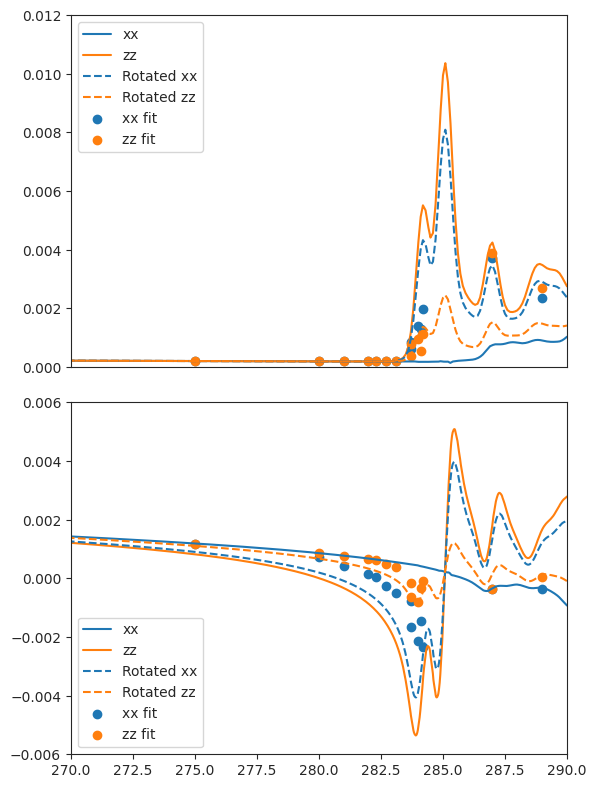

In [ ]:
# pull the csv data from the fitting results

fit = pd.read_csv("optical models/C32H16N8Zn.fit")

fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(6.4, 9.6))

ax[0].plot(en, n[:, 0, 0].imag, label="xx", color="C0")
ax[0].plot(en, n[:, 1, 1].imag, label="zz", color="C1")
ax[0].plot(en, n_r[:, 0, 0].imag, label="Rotated xx", color="C0", linestyle="--")
ax[0].plot(en, n_r[:, 1, 1].imag, label="Rotated zz", color="C1", linestyle="--")

ax[0].scatter(fit["energy"], fit["ixx"], color="C0", label="xx fit")
ax[0].scatter(fit["energy"], fit["izz"], color="C1", label="zz fit")

ax[0].set_xlim(270, 290)
ax[0].set_ylim(0, 0.012)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].legend()

ax[1].plot(en, n[:, 0, 0].real, label="xx", color="C0")
ax[1].plot(en, n[:, 1, 1].real, label="zz", color="C1")
ax[1].plot(en, n_r[:, 0, 0].real, label="Rotated xx", color="C0", linestyle="--")
ax[1].plot(en, n_r[:, 1, 1].real, label="Rotated zz", color="C1", linestyle="--")

ax[1].scatter(fit["energy"], fit["xx"], color="C0", label="xx fit")
ax[1].scatter(fit["energy"], fit["zz"], color="C1", label="zz fit")

ax[1].set_xlim(270, 290)
ax[1].set_ylim(-0.006, 0.006)
ax[1].legend()
display(fit.head())

# Fitting over the complex numbers

Since complex numbers do not originate from ther order axioms, there the residue computed by least squares must be real. To do this, we propose
$$
n = \left(Re[n_xx], Im[n_xx], Re[n_zz], Im[n_zz] \right)
$$

(270.0, 290.0)

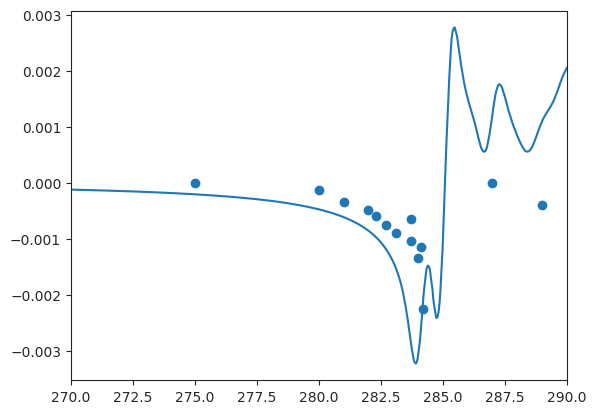

In [ ]:
from scipy.optimize import curve_fit

#  fit the birrefringence data
biref = fit["xx"] - fit["zz"]


plt.scatter(fit["energy"], biref)